In [21]:
library(data.table)
library(ggplot2)
library(dplyr)
library(viridis)
library(qqman)

"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0


In [3]:
#check out angsd results
hwe <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/appc_angsd.hwe.gz")
setnames(hwe, 9, "p")

In [3]:
nrow(hwe)

[1] 6295180

In [73]:
nrow(hwe)

[1] 6295180

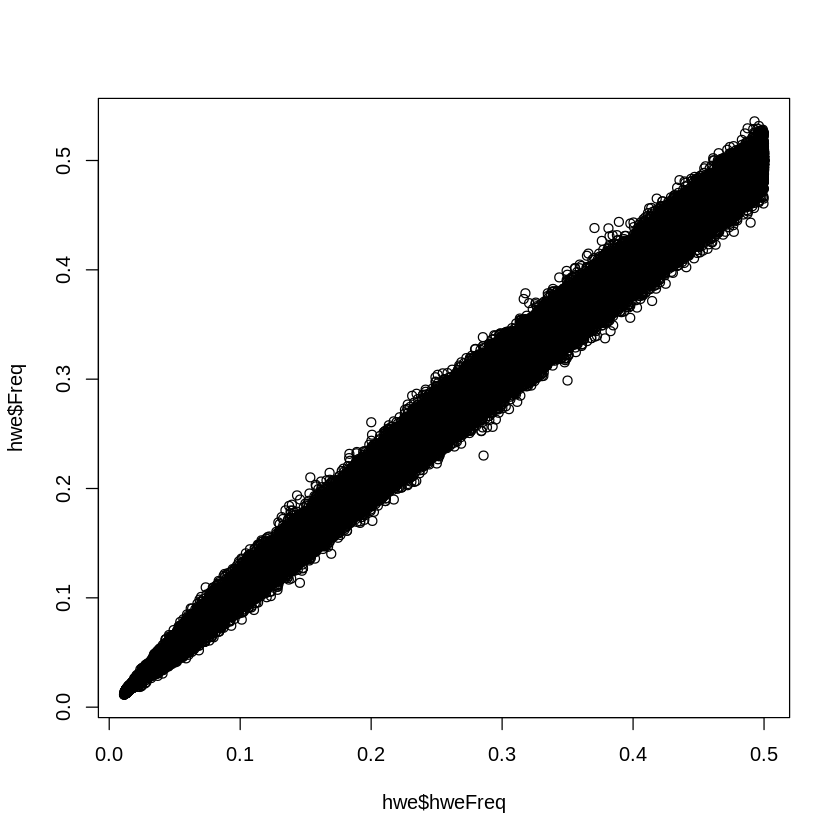

In [9]:
plot(hwe$hweFreq, hwe$Freq) #no super obvious het problems

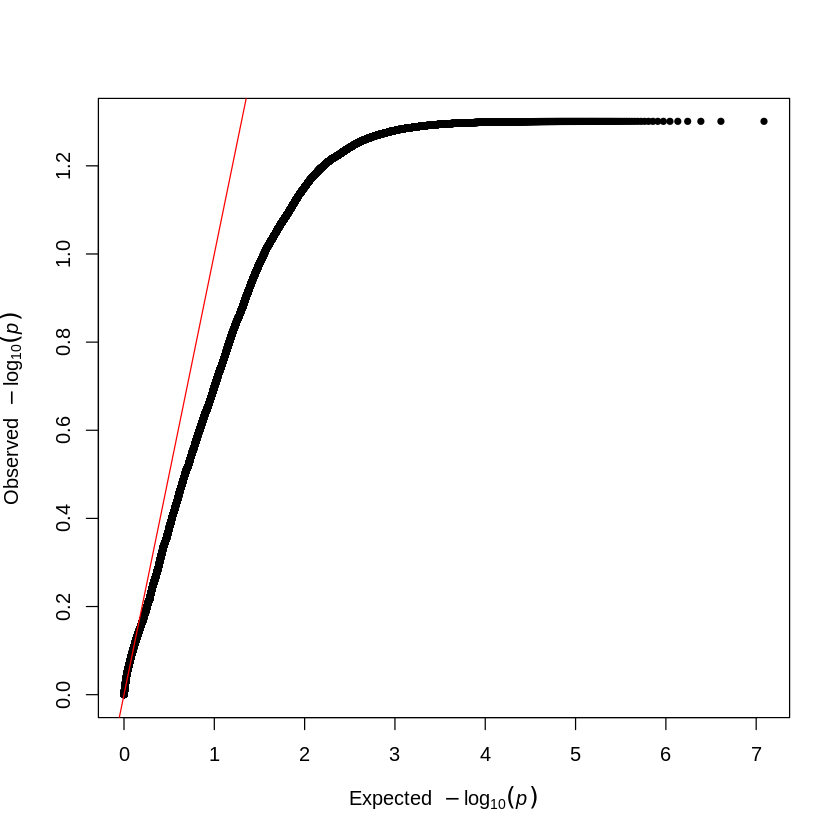

In [15]:
qq(hwe$p)

In [10]:
#how do maf and calls across ind look
maf <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/appc_angsd.mafs.gz")
head(maf)

chromo,position,major,minor,knownEM,pK-EM,nInd
CM009708.1,164,A,G,0.144025,4.856635e-08,28
CM009708.1,479,T,A,0.098202,4.630796e-10,34
CM009708.1,480,T,G,0.167226,5.107026e-14,33
CM009708.1,787,C,T,0.411443,0.000000e+00,23
CM009708.1,1492,T,G,0.122078,1.257505e-11,38
CM009708.1,2973,C,T,0.096310,8.409185e-07,38


In [12]:
#how many snps on each chrom
maf[, .N, by="chromo"]

chromo,N
CM009708.1,318174
CM009709.1,307594
CM009710.1,282218
CM009711.1,270002
CM009712.1,271504
CM009713.1,307815
CM009714.1,313795
CM009715.1,264037
CM009716.1,272549
CM009717.1,366524


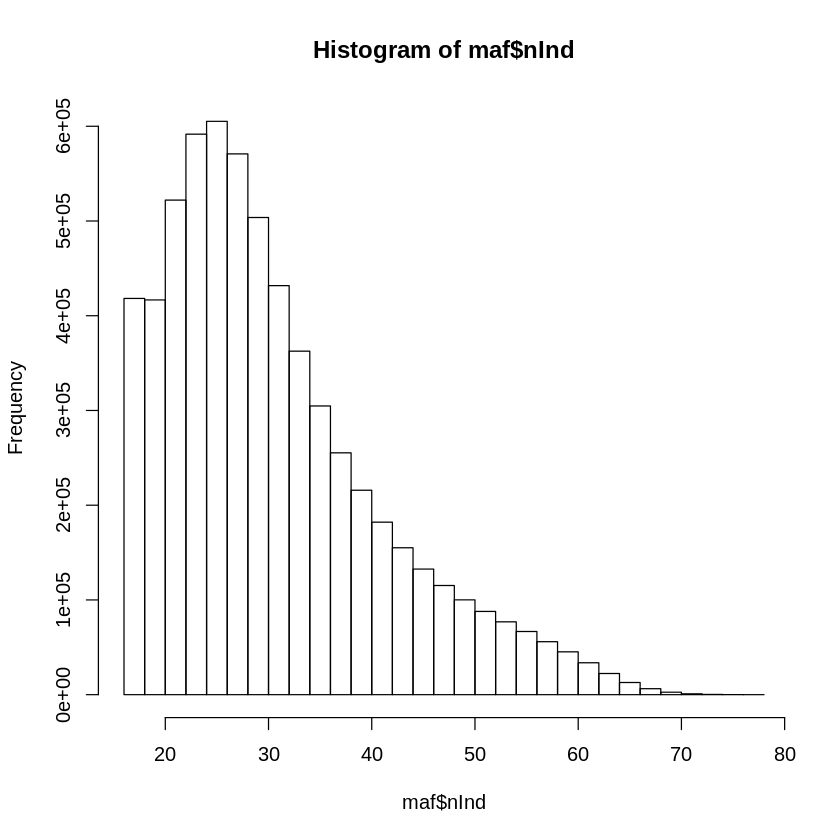

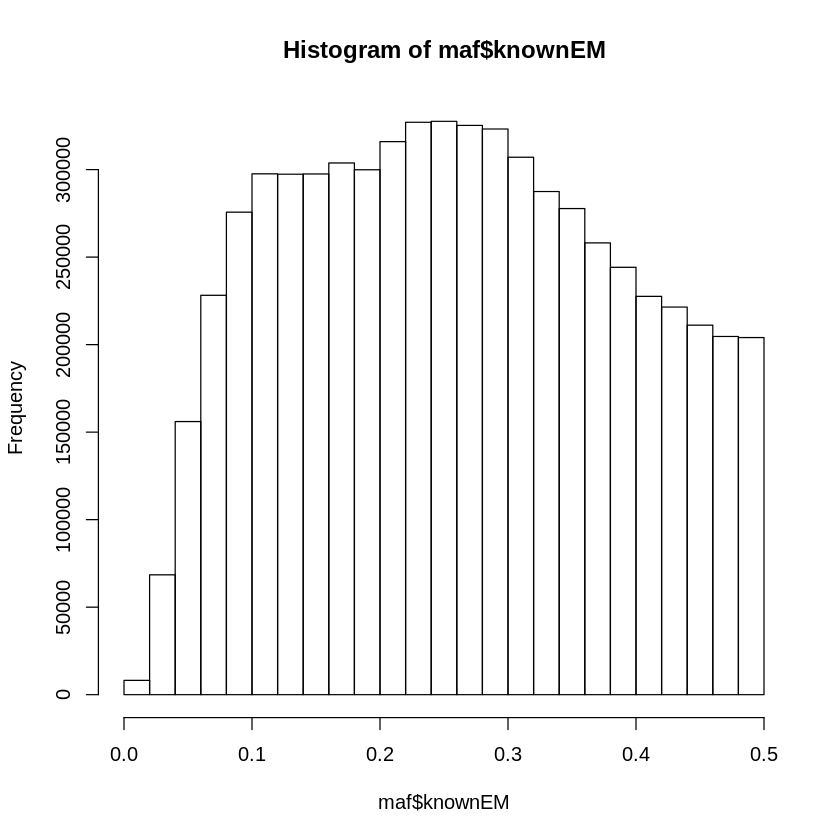

In [11]:
hist(maf$nInd)
hist(maf$knownEM)

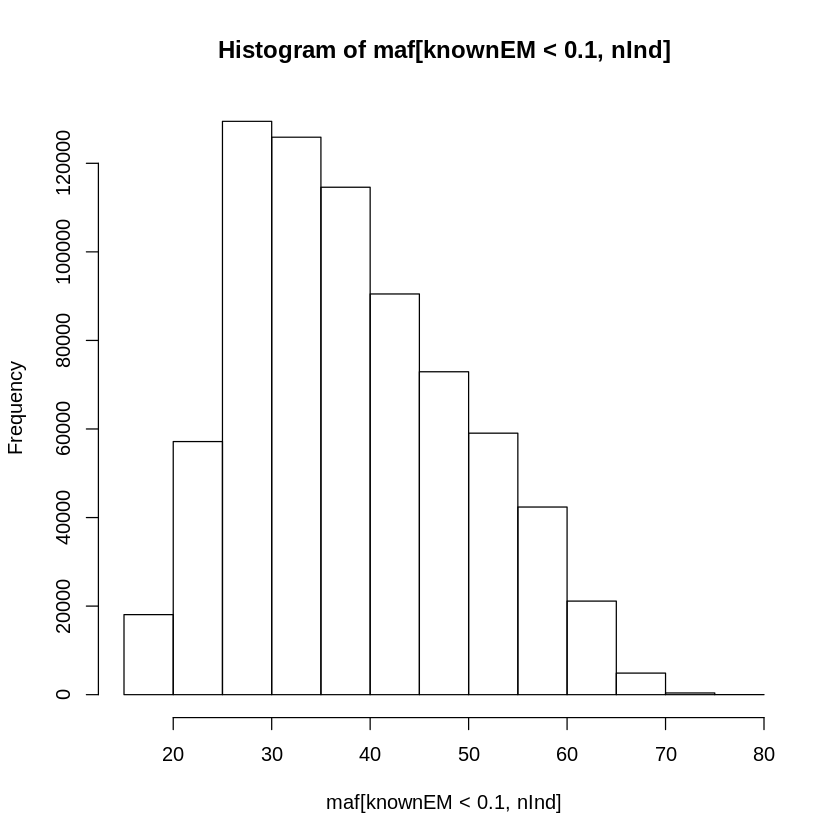

In [13]:
hist(maf[knownEM < 0.1, nInd]) #for the really low maf, what's the distribution of individuals the snp was found in? make sure the nInd GL filter worked as expected

In [16]:
6295181/5886701


[1] 1.06939

In [ ]:
#plot the pcangsd results, color by phenotypes in the association

In [53]:
pca <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/output_appc.pcangsd.cov")

In [71]:
dim(pca)

[1] 159 159

In [55]:
#get eigenvalues
ev <-eigen(pca)
ev_dt <- data.table(ev$vectors[,1:10])
setnames(ev_dt, c("pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9", "pc10"))

In [56]:
#variance explained?
ev$values/sum(ev$values)

[1] 0.206829914 0.006034451 0.006024457 0.006017598 0.006003074 0.005980853
  [7] 0.005974931 0.005937467 0.005927234 0.005916567 0.005900853 0.005882599
 [13] 0.005872271 0.005851542 0.005844765 0.005840228 0.005836907 0.005822896
 [19] 0.005814097 0.005806168 0.005799237 0.005796616 0.005792903 0.005791091
 [25] 0.005777207 0.005775092 0.005770783 0.005768802 0.005767841 0.005763657
 [31] 0.005761442 0.005760527 0.005756444 0.005755918 0.005748545 0.005722951
 [37] 0.005696547 0.005694657 0.005691800 0.005683484 0.005682243 0.005676786
 [43] 0.005670694 0.005665121 0.005652502 0.005630868 0.005615730 0.005607985
 [49] 0.005599380 0.005598167 0.005592927 0.005592309 0.005568314 0.005563256
 [55] 0.005555833 0.005533694 0.005522768 0.005495078 0.005489656 0.005475138
 [61] 0.005441144 0.005387333 0.005355354 0.005302375 0.005272970 0.005086923
 [67] 0.005066823 0.005043846 0.005014204 0.005007674 0.005002733 0.004978922
 [73] 0.004954590 0.004945442 0.004939999 0.004932426 0.004923222 0.004915358
 [79] 0.004909059 0.004903116 0.004889004 0.004885567 0.004879938 0.004853972
 [85] 0.004844131 0.004834638 0.004818525 0.004804259 0.004783251 0.004764398
 [91] 0.004743653 0.004736261 0.004708360 0.004695801 0.004694482 0.004687689
 [97] 0.004686133 0.004683136 0.004678482 0.004649496 0.004637794 0.004636748
[103] 0.004630516 0.004623195 0.004612567 0.004607534 0.004600441 0.004572840
[109] 0.004567105 0.004563595 0.004540756 0.004521229 0.004514375 0.004511322
[115] 0.004506989 0.004497189 0.004487868 0.004466824 0.004455677 0.004443058
[121] 0.004433675 0.004425717 0.004414594 0.004411202 0.004389747 0.004382373
[127] 0.004366196 0.004359568 0.004357634 0.004350863 0.004347620 0.004336724
[133] 0.004334332 0.004332442 0.004327817 0.004319641 0.004315212 0.004312240
[139] 0.004308841 0.004305961 0.004298361 0.004297179 0.004290676 0.004287623
[145] 0.004275728 0.004272554 0.004269600 0.004242467 0.004234681 0.004227907
[151] 0.004187887 0.004168523 0.004149784 0.004092047 0.004082821 0.004051929
[157] 0.004015186 0.003935708 0.003801762

In [57]:
#bamlist <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/bamlist.list.txt")
meta <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), Group :=-999][Group=="High", Group:=1][Group=="Low", Group:=0][, .(sample=gen_id, ucrit=Ucrit, sl=SL, dam, sire, case=Group, capture=Capture)]

#case_control_pheno <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_pheno.ybin")
#setnames(case_control_pheno, "case")
#sl_pheno <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/SL_pheno.ybin")
#setnames(sl_pheno, "sl")
#ucrit_pheno <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Ucrit_pheno.ybin")
#setnames(ucrit_pheno, "ucrit")

In [47]:
head(meta)

sample,ucrit,sl,dam,sire,case,capture
Pop01_APPC1611,8.13,4.40,D125,S144,1,Pop01
Pop01_APPC1917,1.20,4.35,D85,S173,0,Pop01
Pop01_APPC1921,7.33,4.28,D85,S173,1,Pop01
Pop01_APPC2029,8.82,4.25,D70,S98,1,Pop01
Pop01_APPC2030,7.32,4.54,D70,S98,1,Pop01
Pop01_APPC2101,5.07,3.94,D269,S94,1,Pop01


In [ ]:
#meta[, bam_id := paste(Capture, larvalID, sep="_")] #make a name column consistent with bamlist
#join with bamlist
#bam_meta <- left_join(bamlist, meta, by=c(sample="gen_id"))[, .(sample, ucrit=Ucrit, sl=SL, dam, sire, case=Group, capture=Capture)]

In [ ]:
#check that the angsd assoc phenotypes were in the right order
#(bam_meta$case==case_control_pheno$case)
#(bam_meta$ucrit== ucrit_pheno$ucrit)
#(bam_meta$sl== sl_pheno$sl)

In [58]:
pca_phenos <- cbind(meta , ev_dt)[, sequencing_lib := ifelse(capture %in% c("Pop01","Pop02","Pop03", "Pop04", "Pop05", "Pop06", "Pop07","Pop08"), 1, 2)]

In [59]:
head(pca_phenos)

sample,ucrit,sl,dam,sire,case,capture,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,sequencing_lib
Pop01_APPC1611,8.13,4.40,D125,S144,1,Pop01,-0.09105932,-0.0235687934,-0.0079139710,0.0412109891,0.0168615083,0.0537114958,-0.0359606912,0.0764504781,-0.1283674986,0.393337666,1
Pop01_APPC1917,1.20,4.35,D85,S173,0,Pop01,-0.11287407,-0.0096700658,-0.0117397973,0.0168475657,-0.0083213442,0.0121149406,-0.0083088169,0.0095314550,-0.0108510502,0.017622433,1
Pop01_APPC1921,7.33,4.28,D85,S173,1,Pop01,0.00339022,0.0005065348,-0.0001675303,-0.0006793565,-0.0002635271,-0.0008368095,0.0005791246,-0.0005169957,0.0006452577,-0.001049479,1
Pop01_APPC2029,8.82,4.25,D70,S98,1,Pop01,-0.03342338,-0.0297364647,-0.0657117866,0.0974951860,-0.9892081134,-0.0389642288,0.0228377811,-0.0122636206,0.0098691249,-0.013772703,1
Pop01_APPC2030,7.32,4.54,D70,S98,1,Pop01,0.02273052,0.0016938387,-0.0000746425,-0.0024002640,-0.0011974892,-0.0024355341,0.0014788188,-0.0015831584,0.0016686023,-0.002686622,1
Pop01_APPC2101,5.07,3.94,D269,S94,1,Pop01,0.07959967,0.0012877915,-0.0009047563,-0.0020012075,0.0002897115,-0.0017599824,0.0010049590,-0.0010435679,0.0011516542,-0.001684940,1


In [50]:
ForAngsdGWAS <- pca_phenos[, .(sample, phe1=ucrit, phe2=sl, phe3=case, cov1=pc1)]

In [40]:
#fwrite(ForAngsdGWAS, "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ForAngsdGWAS.sample", sep=",")

In [41]:
#fwrite(ForAngsdGWAS[, .(cov1)], "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/pc1.cov")

In [62]:
(pca_phenos[pc4 >0.25])
(pca_phenos[pc4 < -0.75])

sample,ucrit,sl,dam,sire,case,capture,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,sequencing_lib


sample,ucrit,sl,dam,sire,case,capture,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,sequencing_lib
Pop13_APPC0523,8.33,4.32,D119,S162,1,Pop13,-0.07550368,-0.20576,-0.1395484,-0.9524439,-0.06729292,-0.0787795,0.0433786,-0.02463565,0.02501442,-0.03091916,2


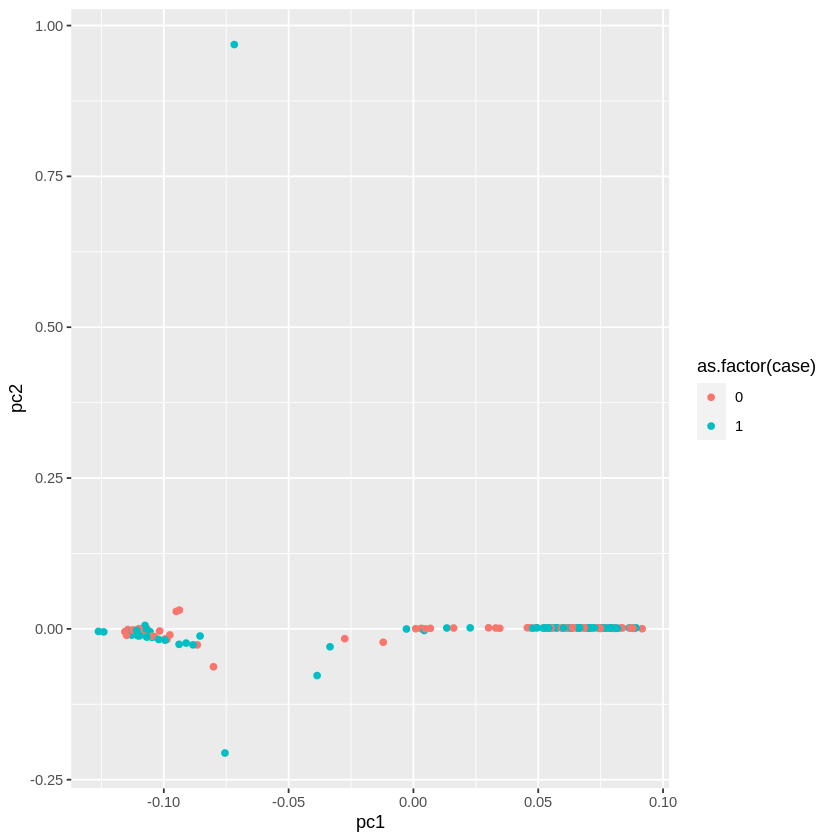

In [63]:
ggplot()+
    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=as.factor(case)))

In [ ]:
p

In [65]:
ggplot()+
    geom_point(data=pca_phenos[], aes(x=pc1, y=pc2, col=sl)) +
    scale_color_viridis(color.palette=magma)

ERROR: Error in continuous_scale(aesthetics, "gradientn", gradient_n_pal(colours, : unused argument (color.palette = magma)


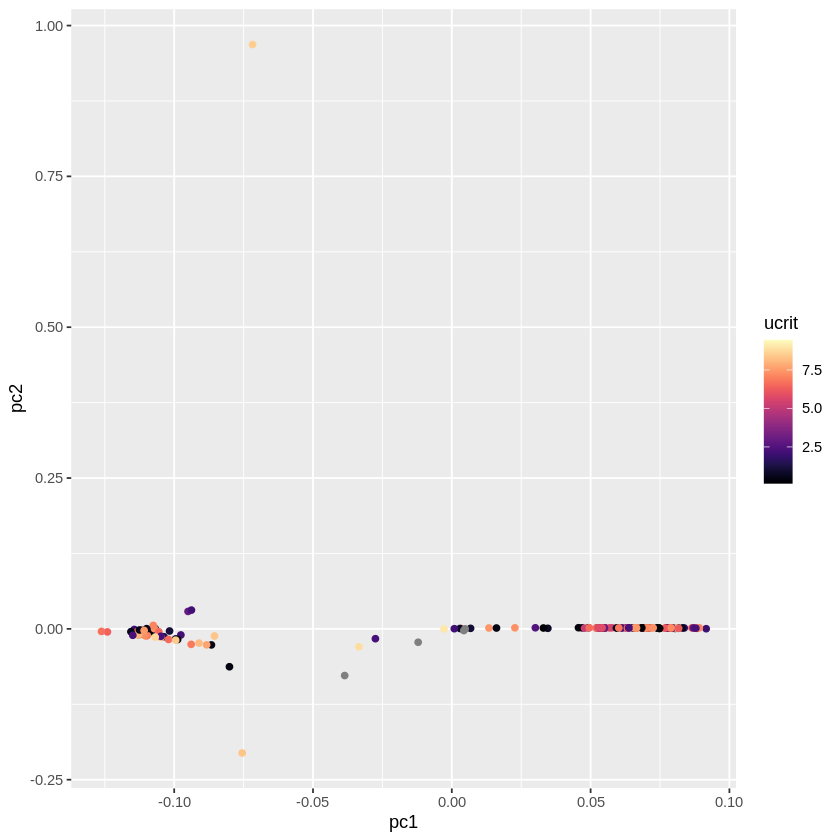

In [66]:
ggplot()+
    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=ucrit)) +
    scale_color_viridis(option="magma")

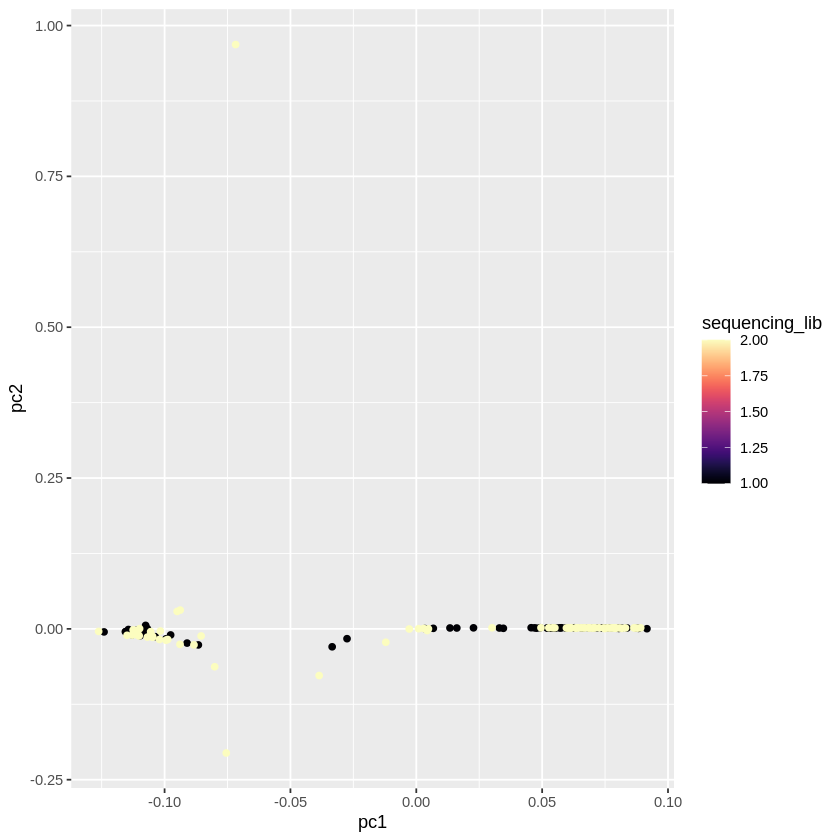

In [67]:
ggplot()+
    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=sequencing_lib)) +
    scale_color_viridis(option="magma")

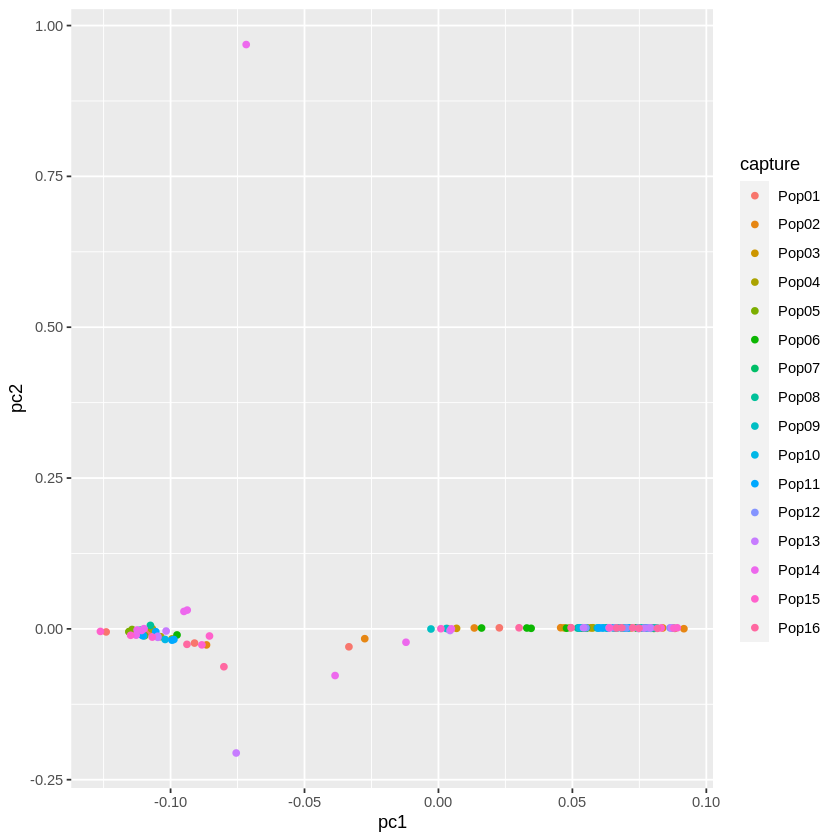

In [34]:
ggplot()+
    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=capture)) 

In [4]:
case_control_lrt <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out.lrt0.gz")
#make a locus column 
case_control_lrt[, locus := paste(Chromosome, Position, sep=":")]

In [5]:
case_control_hwe <- hwe #fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out.hwe.gz")
setnames(case_control_hwe, 9, "p")
#make a locus column 
case_control_hwe[, locus := paste(Chromo, Position, sep=":")]

In [6]:
summary(case_control_hwe[,9])

       p         
 Min.   :0.0500  
 1st Qu.:0.3637  
 Median :0.6026  
 Mean   :0.5716  
 3rd Qu.:0.7771  
 Max.   :1.0000  

In [7]:
head(case_control_hwe)

Chromo,Position,Major,Minor,hweFreq,Freq,F,LRT,p,locus
CM009708.1,164,A,G,0.143948,0.143978,-0.012379,0.004032974,0.9493638,CM009708.1:164
CM009708.1,479,T,A,0.098266,0.099586,-0.109246,0.309823700,0.5777884,CM009708.1:479
CM009708.1,480,T,G,0.167168,0.176823,-0.214118,1.518999000,0.2177710,CM009708.1:480
CM009708.1,787,C,T,0.411355,0.409284,-0.317570,0.795253300,0.3725164,CM009708.1:787
CM009708.1,1492,T,G,0.122028,0.124322,-0.139868,0.466126500,0.4947746,CM009708.1:1492
CM009708.1,2973,C,T,0.096377,0.099344,-0.109185,0.381258200,0.5369306,CM009708.1:2973


In [6]:
#make sure loci not in hwe aren't in GWAS
nrow(case_control_lrt)
nrow(case_control_hwe)
#nope, there are because I set the threshold too low- should use 0.05- do that now
no_hwe_lrt <- case_control_lrt[locus %!in% case_control_hwe[p < 0.05, locus]]
nrow(case_control_lrt)-nrow(case_control_hwe[p < 0.05]) == nrow(no_hwe_lrt) #should be true

#filter other sites that have negative LRT
no_hwe_lrt_filt<-no_hwe_lrt[LRT >0]
nrow(no_hwe_lrt_filt) #number of sites included

[1] 7088713

[1] 6295180

[1] TRUE

[1] 7067808

In [10]:
head(no_hwe_lrt_filt)

Chromosome,Position,Major,Minor,Frequency,LRT,locus
CM009708.1,164,A,G,0.144025,1.171608,CM009708.1:164
CM009708.1,479,T,A,0.098202,0.255226,CM009708.1:479
CM009708.1,480,T,G,0.167226,0.117581,CM009708.1:480
CM009708.1,529,C,A,0.168935,0.125478,CM009708.1:529
CM009708.1,787,C,T,0.411443,0.743850,CM009708.1:787
CM009708.1,1492,T,G,0.122078,0.052974,CM009708.1:1492


In [7]:
#format for manhattan plot
#get pvalues
no_hwe_lrt_filt$pvalue<-dchisq(no_hwe_lrt_filt$LRT, df=1)
no_hwe_lrt_filt[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
no_hwe_lrt_filt[, Chromosome := as.numeric(Chromosome)]


In [8]:
no_hwe_lrt_filt$SNP<-paste("r",1:length(no_hwe_lrt_filt$Chromosome), sep="")

In [9]:
head(no_hwe_lrt_filt)

Chromosome,Position,Major,Minor,Frequency,LRT,locus,pvalue,SNP
97081,164,A,G,0.144025,1.171608,CM009708.1:164,0.2051670,r1
97081,479,T,A,0.098202,0.255226,CM009708.1:479,0.6950659,r2
97081,480,T,G,0.167226,0.117581,CM009708.1:480,1.0970062,r3
97081,529,C,A,0.168935,0.125478,CM009708.1:529,1.0577403,r4
97081,787,C,T,0.411443,0.743850,CM009708.1:787,0.3188911,r5
97081,1492,T,G,0.122078,0.052974,CM009708.1:1492,1.6880120,r6


In [10]:
#What's the highest pvalue we get with the permuted phenotypes?
case_control_lrt_NULL <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out_NULL.lrt0.gz")
case_control_lrt_NULL[, locus := paste(Chromosome, Position, sep=":")]
no_hwe_lrt_NULL <- case_control_lrt_NULL[locus %!in% case_control_hwe[p < 0.05, locus]]
nrow(no_hwe_lrt_NULL) == nrow(no_hwe_lrt) #should be true

#filter other sites that have negative LRT
no_hwe_lrt_filt_NULL<-no_hwe_lrt_NULL[LRT >0]
nrow(no_hwe_lrt_filt_NULL) #number of sites included
no_hwe_lrt_filt_NULL$pvalue<-dchisq(no_hwe_lrt_filt_NULL$LRT, df=1)
summary(no_hwe_lrt_filt_NULL$pvalue)

Warning message in fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out_NULL.lrt0.gz"):
“Discarded single-line footer: <<CM00972>>”

[1] FALSE

[1] 4415623

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.1636   0.4526   2.0543   1.1442 398.9421 

In [11]:
min(no_hwe_lrt_filt_NULL$pvalue)
min(no_hwe_lrt_filt$pvalue)

[1] 1.358339e-06

[1] 3.455997e-08

In [87]:
#candidates <- no_hwe_lrt_filt[LRT > max(case_control_lrt_NULL$LRT)]

In [ ]:
#no_hwe_lrt_filt[pvalue < min(no_hwe_lrt_filt_NULL$pvalue)]

In [90]:
#(candidates)

Chromosome,Position,Major,Minor,Frequency,LRT,locus,pvalue,SNP
97091,16016301,A,T,0.420916,27.49578,CM009709.1:16016301,8.140381e-08,r457958
97101,28234957,C,T,0.437653,23.30957,CM009710.1:28234957,7.170255e-07,r896790
97131,37957666,C,G,0.391876,23.59117,CM009713.1:37957666,6.191233e-07,r1952891
97151,38909563,T,C,0.419653,22.48597,CM009715.1:38909563,1.102015e-06,r2621157
97181,27595087,C,T,0.399784,29.15078,CM009718.1:27595087,3.455997e-08,r3551971
97191,25058095,A,T,0.277069,25.12561,CM009719.1:25058095,2.785450e-07,r3841142
97231,3558599,C,G,0.423649,22.73351,CM009723.1:3558599,9.684058e-07,r4859309
97291,13747328,A,G,0.415023,22.58004,CM009729.1:13747328,1.049188e-06,r6516672
97301,653787,C,T,0.154713,24.16069,CM009730.1:653787,4.601800e-07,r6650740


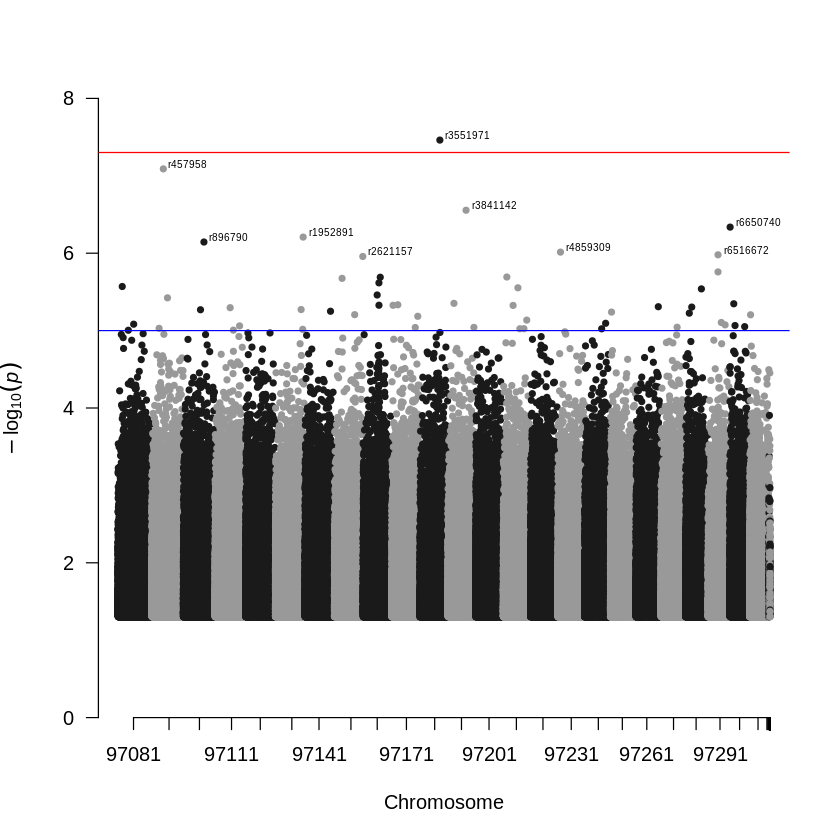

In [18]:
library(qqman)
man <- manhattan(no_hwe_lrt_filt[pvalue <0.05], chr="Chromosome", bp="Position", p="pvalue", annotatePval =min(no_hwe_lrt_filt_NULL$pvalue))

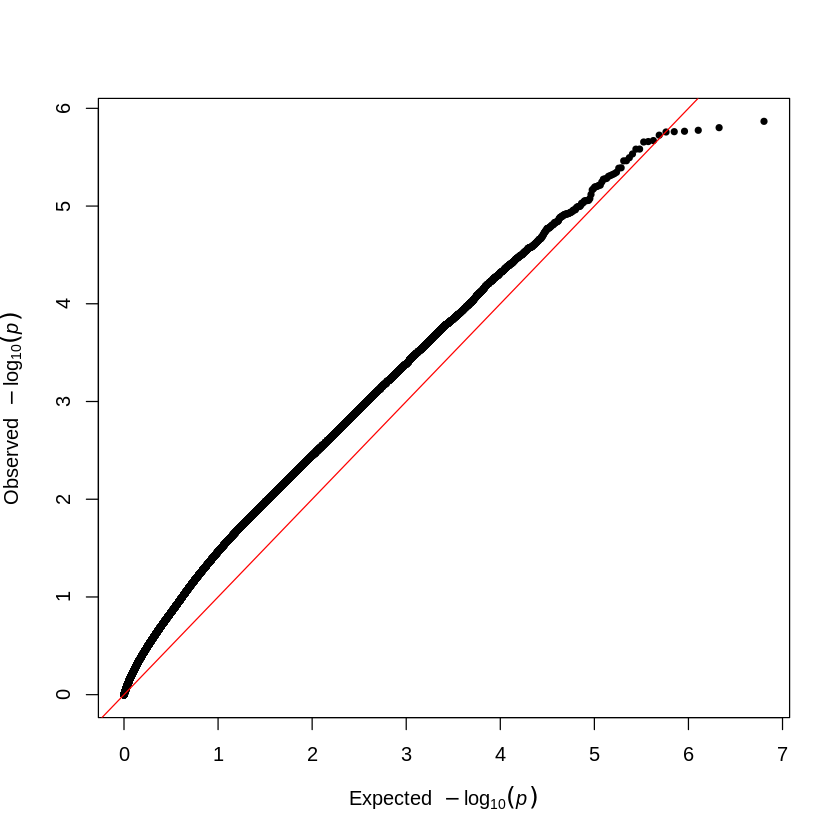

In [13]:
#library(qqman)
qq(no_hwe_lrt_filt_NULL$pvalue) 

In [12]:
summary(no_hwe_lrt_filt_NULL$pvalue)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.1636   0.4526   2.0543   1.1442 398.9421 

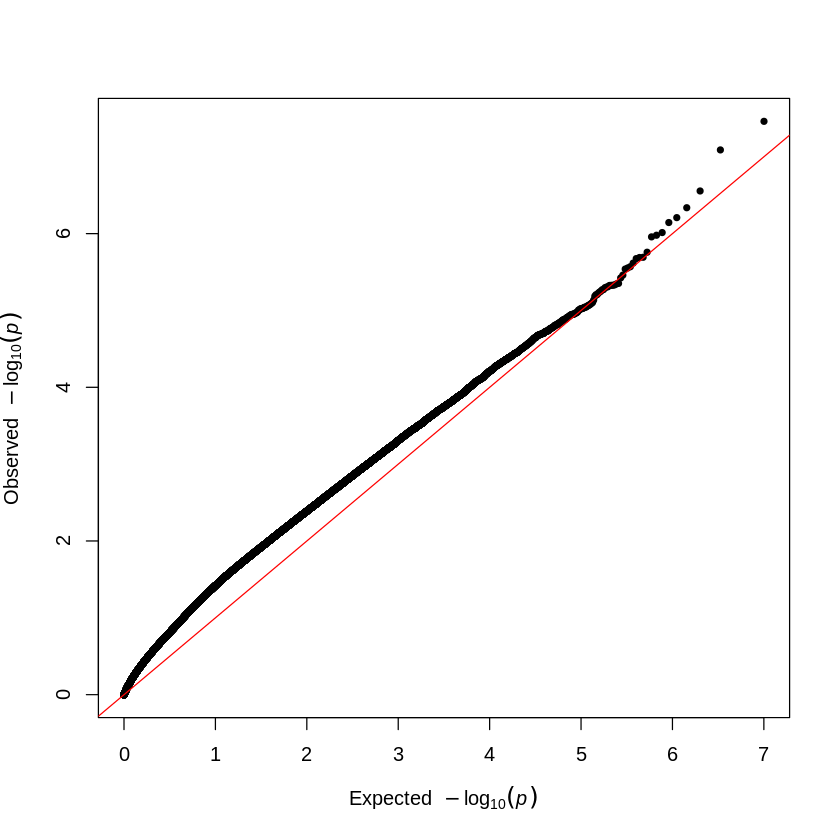

In [14]:
qq(no_hwe_lrt_filt$pvalue) #if the analysis structure is correct, then most points will be a line (because the null of "no association" is true for these) and there's a tail with a higher than expected sample p value


In [22]:
#does increasing minCount to 30 help?
mincount30 <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out_minCount30.lrt0.gz")

Warning message in fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out_minCount30.lrt0.gz"):
“Discarded single-line footer: <<CM009718.1	213>>”

In [24]:
nrow(mincount30)

[1] 3356430

In [26]:
nrow(mincount30)/nrow(case_control_lrt) #run didn't finish, but we got halfway through so hopefully that's enough to get an idea of whether it helped

[1] 0.4734893

In [27]:
mincount30[, locus := paste(Chromosome, Position, sep=":")]
no_hwe_lrt_mincount30 <- mincount30[locus %!in% case_control_hwe[p < 0.05, locus]]

#filter other sites that have negative LRT
no_hwe_lrt_filt_mincount30<-no_hwe_lrt_mincount30[LRT >0]
nrow(no_hwe_lrt_filt_mincount30) #number of sites included
no_hwe_lrt_filt_mincount30$pvalue<-dchisq(no_hwe_lrt_filt_mincount30$LRT, df=1)
summary(no_hwe_lrt_filt_mincount30$pvalue)

[1] 3346597

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.1791   0.4805   2.1787   1.1990 398.9421 

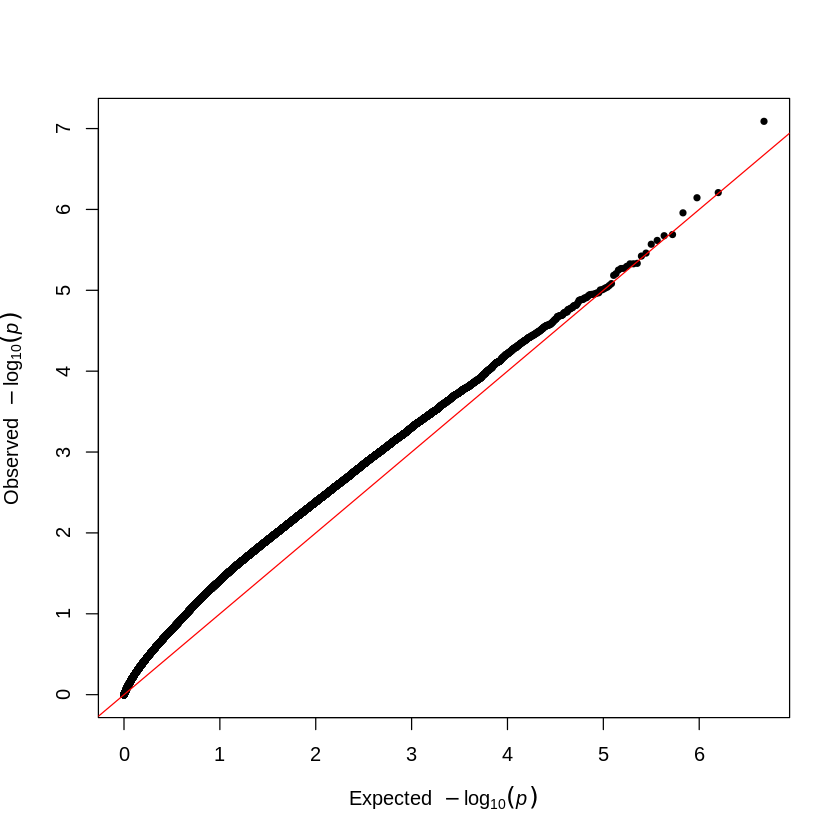

In [28]:
qq(no_hwe_lrt_filt_mincount30$pvalue) #okay no not really0 proceed with LD filtering to see if that helps

In [19]:
#hmmmm... do we have the same issues when it's with the score+EM assoc?
cc_do_assoc5 <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_doAssoc5_out.lrt0.gz")
head(cc_do_assoc5)

Chromosome,Position,Major,Minor,Frequency,N,LRTscore,high_WT/HE/HO,LRTem,beta,SE,emIter
CM009708.1,164,A,G,0.455804,159,-999,3/1/0,NaN,NaN,NaN,0
CM009708.1,479,T,A,0.434662,159,-999,3/3/0,NaN,NaN,NaN,0
CM009708.1,480,T,G,0.444954,159,-999,2/6/0,NaN,NaN,NaN,0
CM009708.1,787,C,T,0.490851,159,-999,1/3/0,NaN,NaN,NaN,0
CM009708.1,1492,T,G,0.432884,159,-999,3/3/0,NaN,NaN,NaN,0
CM009708.1,2973,C,T,0.428961,159,-999,5/3/0,NaN,NaN,NaN,0


In [20]:
summary(cc_do_assoc5$LRTscore)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -999    -999    -999    -999    -999    -999 

In [16]:
#what about SL ?
sl_assoc <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/SL_quant_assoc_out.lrt0.gz")
head(sl_assoc)

Chromosome,Position,Major,Minor,Frequency,N,LRTscore,high_WT/HE/HO,LRTem,beta,SE,emIter
CM009708.1,164,A,G,0.455804,147,-999,3/0/0,NaN,NaN,NaN,0
CM009708.1,479,T,A,0.434662,147,-999,3/2/0,NaN,NaN,NaN,0
CM009708.1,480,T,G,0.444954,147,-999,2/5/0,NaN,NaN,NaN,0
CM009708.1,787,C,T,0.490851,147,-999,1/3/0,NaN,NaN,NaN,0
CM009708.1,1492,T,G,0.432884,147,-999,3/3/0,NaN,NaN,NaN,0
CM009708.1,2973,C,T,0.428961,147,-999,4/2/0,NaN,NaN,NaN,0


In [18]:
summary(sl_assoc$LRT)

Length  Class   Mode 
     0   NULL   NULL 

In [ ]:
sl_assoc$pvalue<-dchisq(no_hwe_lrt_filt$LRT, df=1)

In [ ]:
#are these SNPs also in the SL Gwas?
#What's the highest pvalue we get with the permuted phenotypes?
#sl_lrt <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/SL_quant_assoc_out.lrt0.gz")
#sl_lrt[, locus := paste(Chromosome, Position, sep=":")]
#no_hwe_lrt_sl <- sl_lrt[locus %!in% case_control_hwe[p < 0.05, locus]]
#nrow(no_hwe_lrt) == nrow(no_hwe_lrt) #should be true

#filter other sites that have negative LRT
no_hwe_lrt_filt_sl<-no_hwe_lrt_sl[LRTscore >0]
nrow(no_hwe_lrt_filt_sl) #number of sites included
no_hwe_lrt_filt_sl$pvalue<-dchisq(no_hwe_lrt_filt_sl$LRTscore, df=1)
summary(no_hwe_lrt_filt_sl$pvalue)

In [ ]:
head(no_hwe_lrt_filt_sl[!is.na(beta)])

In [ ]:
qqnorm(no_hwe_lrt_filt_sl$pvalue)

In [ ]:
#lrt<-read.table(gzfile("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out.lrt0.gz"), header=T, sep="\t")
#setDT(lrt)
#lrt <- lrt[LRT >0]

In [ ]:
ordered <- case_control_lrt_filt[order(pvalue)]

In [ ]:
(ordered[1:100])

In [ ]:
summary(case_control_lrt_filt$pvalue)

In [ ]:
#plot maf from angsd
maf<-fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out.mafs.gz")
setDT(maf)

In [ ]:
head(maf)

In [ ]:
hist(maf$nInd)
summary(maf$nInd)

In [ ]:
summary(maf$knownEM)
hist(maf$knownEM)

In [ ]:
library(ape)
features <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/ncbi-genomes-2022-02-28//GCA_003047355.2_Nemo_v1.1_genomic.gbff.gff", skip = 6)

In [ ]:
head(features)